In [1]:
#Dataset contains Monthly and Daily prices of Natural gas, starting from January 1997 to current
#year. Prices are in nominal dollars. The task is to predict the price of natural gas using RNN model
#for the dataset.
#Given the price of last ten 10 days, corresponds to sequence_length, the RNN model must predict
#the price for the 11th day

In [47]:
import numpy as np
import torch 
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import torch.nn as nn

#load data
df = pd.read_csv('daily_csv.csv')
df.dropna(inplace = True)
y = df['Price'].values
#x = np.arange(1, len(y), 1)

#normalize
min = y.min()
max = y.max()
y = [(i-min)/(max - min) for i in y]

#divide into sequence and output
sequence_length = 10
X = []
Y = []
for i in range(0, 5900):
    l = []
    for j in range(i, i + sequence_length):
        l.append(y[j])
    X.append(l)
    Y.append(y[j + 1])

X = np.array(X)
Y = np.array(Y)

#train text split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.1, random_state = 42, shuffle = False, stratify = None)

class custom_dataset(Dataset):
    def __init__(self, x, y):
        self.x = torch.tensor(x, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
        self.len = x.shape[0]

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

    def __len__(self):
        return self.len

data = custom_dataset(x_train, y_train)
train_loader = DataLoader(data, shuffle = True, batch_size = 256)

#define RNN class
class RNN_gas(nn.Module):
    def __init__(self):
        super(RNN_gas, self).__init__()
        self.rnn = nn.RNN(input_size = 1, hidden_size = 5, num_layers = 1, batch_first = True)
        self.fc1 = nn.Linear(in_features = 5, out_features = 1)

    def forward(self,x ):
        output, _status = self.rnn(x)
        output = output[:,-1,:]
        output = self.fc1(torch.relu(output))
        return output
        
#define loss and optimizer
model = RNN_gas()
model.to('cuda')
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
epochs = 400
losses = []

#training loop
for i in range(epochs):
    for j, data in enumerate(train_loader):
        inp, out = data
        inp = inp.to('cuda')
        out= out.to('cuda')
        y_pred = model(inp.view(-1, sequence_length, 1)).reshape(-1)
        loss = criterion(y_pred, out)
        loss.backward()
        optimizer.step()
    losses.append(loss.item())
    if i%100 == 0:
        print("[ " + str(i) + " ] loss:" + str(loss.item()))       




[ 0 ] loss:0.2878158390522003
[ 100 ] loss:0.11572659760713577
[ 200 ] loss:0.12052473425865173
[ 300 ] loss:0.12824682891368866


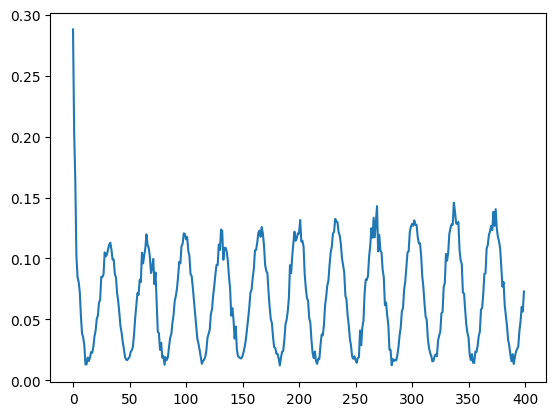

In [49]:
plt.plot([i for i in range(0, len(losses))], losses)
plt.show()

In [80]:
#The data provided at the link https://download.pytorch.org/tutorial/data.zip consists of
#names stored in the format {language: [names ...]} i.e. each language contains a list of
#names. Train a RNN on a few thousand surnames from 18 languages of origin, and
#predict which language a name is from based on the spelling.

#load data
import os
labels = []
names = []
nation_num = 0
max_length = None
files = ['names/' + str(f) for f in os.listdir('names/')]
for file_name in files: 
    f = open(file_name, "r")
    read_obj = f.read()
    ls_names = read_obj.split('\n')
    for j in ls_names:
        num_list = [ord(k) for k in j]
        for i in range(len(num_list), 20):
            num_list.append(0)
        #found that max length of last name = 20, therefore size after padding = 20
        names.append(num_list)
        if max_length == None or len(num_list) > max_length:
            max_length = len(num_list)
        #print(j)
        #print(num_list)
    for j in range(0, len(ls_names)):
        labels.append(nation_num)
    nation_num +=1
#labels_set = set(labels)
#print(len(names))
#print(len(labels))
#print(max_length)

class custom_dataset(Dataset):
    def __init__(self, x, y):
        self.x = torch.tensor(x, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
        self.len = len(x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

    def __len__(self):
        return self.len

data = custom_dataset(names, labels)
train_loader = DataLoader(data, shuffle = True, batch_size = 100)

class RNN_names(nn.Module):
    def __init__(self):
        super(RNN_names, self).__init__()
        self.rnn = nn.RNN(input_size = 1, hidden_size = 12, num_layers = 1, batch_first = True)
        self.fc1 = nn.Linear(in_features = 12, out_features = 1)

    def forward(self,x ):
        output, _status = self.rnn(x)
        #print(output.shape)
        output = output[:,-1,:]
        output = self.fc1(torch.relu(output))
        return output

model = RNN_names()
model.to('cuda')
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
epochs = 200
sequence_length = 20
losses = []

#training loop
for i in range(epochs):
    for j, data in enumerate(train_loader):
        inp, out = data
        #print(inp.shape)
        #print(out.shape)
        inp = inp.to('cuda')
        out= out.to('cuda')
        y_pred = model(inp.view(-1, sequence_length, 1)).reshape(-1)
        #print(y_pred.shape)
        loss = criterion(y_pred, out)
        loss.backward()
        optimizer.step()
    losses.append(loss.item())
    if i%100 == 0:
        print("[ " + str(i) + " ] loss:" + str(loss.item()))       


[ 0 ] loss:3210.47314453125
[ 100 ] loss:3151.6865234375
